<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/cicids2017_imbalanced_augmented_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection based on CICIDS 2017 DataSet 

We use Conv1d, Conv2d, PCA, RF, and knn to implement intrustion detection. Those intrusion detection methods are based on the CICIDS2017 dataset with two new augmented features: the number of flows associated with source and destination IPs.

In [2]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        print(df)

In [4]:
def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

In [5]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

## Step 1. Loading csv files

The augmented csv file contains the two new features.

In [6]:
# All columns
col_names = np.array(['dstflow','srcflow','Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

### Case 1: Connect to Google Drive if run this notebook on Colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# load three csv files generated by mlp4nids (Multi-layer perceptron for network intrusion detection )
# first load the train set
df = pd.read_csv('/content/drive/My Drive/CICIDS2017/cicids2017_ext.csv',names=col_names, skiprows=1)  

### Case 2: accessing a local copy of the augmented dataset

In [ ]:
dataroot = 'cicids2017clean/cicids2017_ext.csv'
df = pd.read_csv(dataroot,names=col_names, skiprows=1) 

## Step 2. Data processing and exploration

In [8]:
# Here we can see the number of rows and columns for each table.
print(df.shape)

(2827876, 74)


In [11]:
df.head()

,dstflow,srcflow,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1352,1,443,54865,6,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,1352,8,80,55054,6,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,1352,8,80,55055,6,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,1185,1,443,46236,6,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,1352,8,443,54863,6,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
df.describe()

,dstflow,srcflow,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06
mean,7.258374e+04,5.831850e+04,4.113793e+04,8.061534e+03,9.884209e+00,1.480065e+07,9.368972e+00,1.040396e+01,5.498522e+02,1.617903e+04,2.078044e+02,1.872929e+01,5.825628e+01,6.897811e+01,8.717304e+02,4.108922e+01,3.062575e+02,3.356657e+02,1.491719e+06,7.085423e+04,1.299765e+06,2.922231e+06,9.191785e+06,1.625442e+05,1.449765e+07,2.612839e+06,3.270269e+06,9.052107e+06,1.022929e+06,9.903861e+06,1.807615e+06,1.487480e+06,4.689442e+06,9.682420e+05,4.639595e-02,1.113910e-04,-2.602379e+04,-2.275588e+03,6.393010e+04,7.002284e+03,1.644888e+01,9.513591e+02,1.721137e+02,2.952720e+02,4.866468e+05,3.528266e-02,4.639595e-02,2.425849e-04,2.982836e-01,3.153147e-01,9.482948e-02,1.113910e-04,2.436458e-04,6.838443e-01,1.921707e+02,5.825628e+01,3.062575e+02,9.368972e+00,5.498417e+02,1.040396e+01,1.617869e+04,6.992389e+03,1.988290e+03,5.423519e+00,-2.744494e+03,8.163400e+04,4.117582e+04,1.533378e+05,5.835492e+04,8.324468e+06,5.043548e+05,8.704568e+06,7.928061e+06
std,8.215552e+04,7.406983e+04,2.229161e+04,1.827432e+04,5.263117e+00,3.366750e+07,7.500527e+02,9.978937e+02,9.998639e+03,2.264235e+06,7.175183e+02,6.035533e+01,1.861733e+02,2.813212e+02,1.947157e+03,6.888118e+01,6.054855e+02,8.400508e+02,2.594016e+07,2.544154e+05,4.510039e+06,8.049410e+06,2.447019e+07,2.951772e+06,3.358966e+07,9.530187e+06,9.643379e+06,2.453990e+07,8.595729e+06,2.874945e+07,8.891515e+06,6.281472e+06,1.716900e+07,8.313137e+06,2.103411e-01,1.055361e-02,2.106353e+07,1.452945e+06,2.476542e+05,3.817038e+04,2.524615e+01,2.029034e+03,3.055985e+02,6.320510e+02,1.648252e+06,1.844934e-01,2.103411e-01,1.557325e-02,4.575047e-01,4.646412e-01,2.929793e-01,1.055361e-02,1.560726e-02,6.805824e-01,3.319734e+02,1.861733e+02,6.054855e+02,7.500527e+02,9.985113e+03,9.978937e+02,2.264204e+06,1.434022e+04,8.454537e+03,6.367482e+02,1.085539e+06,6.489234e+05,3.935787e+05,1.026333e+06,5.773818e+05,2.364057e

Examine the class label imbalance

In [11]:
df['Label'].value_counts()

BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

## Step 3. Split dataset

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [9]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.25)
train_df, val_df = train_test_split(train_df, test_size=0.25)

In [13]:
print('Training dataset shape:', train_df.shape)
print('Validation dataset shape:', val_df.shape)
print('Test dataset shape:', test_df.shape)

Training dataset shape: (1590680, 74)
Validation dataset shape: (530227, 74)
Test dataset shape: (706969, 74)


Distribution of different attack cases

In [15]:
print('Train dataset: ')
train_df['Label'].value_counts()

Train dataset: 


BENIGN                        1277578
DoS Hulk                       129665
PortScan                        89108
DDoS                            72056
DoS GoldenEye                    5804
FTP-Patator                      4424
DoS slowloris                    3301
SSH-Patator                      3282
DoS Slowhttptest                 3119
Bot                              1107
Web Attack � Brute Force          837
Web Attack � XSS                  367
Infiltration                       17
Web Attack � Sql Injection          9
Heartbleed                          6
Name: Label, dtype: int64

In [16]:
print('Validation dataset: ')
val_df['Label'].value_counts()

Validation dataset: 


BENIGN                        425407
DoS Hulk                       43466
PortScan                       30008
DDoS                           23965
DoS GoldenEye                   1905
FTP-Patator                     1526
SSH-Patator                     1098
DoS slowloris                   1046
DoS Slowhttptest                1022
Bot                              353
Web Attack � Brute Force         292
Web Attack � XSS                 124
Infiltration                       7
Web Attack � Sql Injection         6
Heartbleed                         2
Name: Label, dtype: int64

In [17]:
print('Test dataset: ')
test_df['Label'].value_counts()

Test dataset: 


BENIGN                        568335
DoS Hulk                       56993
PortScan                       39688
DDoS                           32004
DoS GoldenEye                   2584
FTP-Patator                     1985
SSH-Patator                     1517
DoS slowloris                   1449
DoS Slowhttptest                1358
Bot                              496
Web Attack � Brute Force         378
Web Attack � XSS                 161
Infiltration                      12
Web Attack � Sql Injection         6
Heartbleed                         3
Name: Label, dtype: int64

In [11]:
# Form np arrays of labels and features.
train_labels = encode_label((train_df.pop('Label')).values)
val_labels = encode_label((val_df.pop('Label')).values)
test_labels = encode_label((test_df.pop('Label')).values)

# Label column is already removed
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [15]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1590680,)
Validation labels shape: (530227,)
Test labels shape: (706969,)
Training features shape: (1590680, 73)
Validation features shape: (530227, 73)
Test features shape: (706969, 73)


## Step 4. Normalization

The continuous feature values are normalized into the same feature space. This is important when using features that have different measurements, and is a general requirement of many machine learning algorithms. Therefore, the values for this dataset are also normalized using the Min-Max scaling technique, bringing them all within a range of [0,1].

### Step 4.1 Normalizing train dataset

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
X_train

array([[6.23245226e-01, 6.23694187e-01, 6.51071946e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.32033443e-01, 2.38648939e-01, 9.22468910e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.03370717e-02, 3.26989035e-01, 7.72411688e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.71456714e-05, 3.26989035e-01, 8.03234913e-01, ...,
        5.19350603e-05, 8.33333000e-02, 8.32498167e-02],
       [1.00000000e+00, 1.00000000e+00, 8.06897078e-01, ...,
        0.00000000e+00, 8.25833333e-01, 8.25833333e-01],
       [7.75590612e-05, 8.76729639e-02, 7.66552224e-01, ...,
        8.81747444e-03, 4.90833333e-01, 4.82500000e-01]])

### Step 4.1. Normalizing validation dataset

In [14]:
scaler = MinMaxScaler()
X_val = scaler.fit_transform(val_features)
X_val

array([[7.63956753e-04, 1.34599838e-01, 6.49820706e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.90197310e-01, 1.34760735e-01, 7.70931563e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.28228396e-04, 9.56864007e-02, 7.35042344e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 5.54665446e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.97333519e-02, 7.15205124e-02, 9.19539178e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.11445391e-01, 4.48352183e-02, 7.07698177e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Step 4.3. Normalizing test dataset

In [15]:
scaler = MinMaxScaler()
X_test = scaler.fit_transform(test_features)
X_test

array([[2.68005336e-02, 5.16046495e-03, 1.22072175e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.03307118e-04, 8.76729639e-02, 8.16601816e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 8.77088579e-01, ...,
        0.00000000e+00, 7.21666667e-01, 7.21666667e-01],
       ...,
       [2.32033443e-01, 2.38648939e-01, 9.19096666e-01, ...,
        0.00000000e+00, 8.75000000e-01, 8.75000000e-01],
       [1.38442924e-02, 1.34760735e-01, 9.66201266e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.57854406e-03, 1.56972318e-05, 6.75974670e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Step 5. One-hot encoding for labels

train_labels, test_labels and val_labels have to be one-hot-encoded. That means they must have dimension (number_of_samples, 15), where 15 denotes number of classes.

In [16]:
from tensorflow.keras.utils import to_categorical

Save the labels for AdaBoostClassifier

In [17]:
y_train_ada = train_labels
y_test_ada = test_labels
y_val_ada = val_labels

In [18]:
y_train = to_categorical(train_labels, 15)
y_test = to_categorical(test_labels, 15)
y_val = to_categorical(val_labels, 15)

## Step 4. Define the metrics

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [24]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

## Step 5. Define a baseline model

In [28]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(y_train.shape[-1], activation='softmax',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [29]:
EPOCHS = 30
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [31]:
model_base = make_model()
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1184      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                255       
Total params: 1,439
Trainable params: 1,439
Non-trainable params: 0
_________________________________________________________________


In [32]:
baseline_history = model_base.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/30
777/777 [==============================] - 13s 12ms/step - loss: 0.2896 - tp: 421674.5180 - fp: 75933.4640 - tn: 11091751.8278 - fn: 376017.2661 - accuracy: 0.9553 - precision: 0.7684 - recall: 0.4060 - auc: 0.8983 - val_loss: 0.0374 - val_tp: 459816.0000 - val_fp: 50040.0000 - val_tn: 7373138.0000 - val_fn: 70411.0000 - val_accuracy: 0.9849 - val_precision: 0.9019 - val_recall: 0.8672 - val_auc: 0.9905
Epoch 2/30
777/777 [==============================] - 8s 11ms/step - loss: 0.0540 - tp: 667438.5643 - fp: 65433.8149 - tn: 11102250.7995 - fn: 130253.2198 - accuracy: 0.9833 - precision: 0.9072 - recall: 0.8349 - auc: 0.9881 - val_loss: 0.0269 - val_tp: 468706.0000 - val_fp: 12564.0000 - val_tn: 7410614.0000 - val_fn: 61521.0000 - val_accuracy: 0.9907 - val_precision: 0.9739 - val_recall: 0.8840 - val_auc: 0.9931
Epoch 3/30
777/777 [==============================] - 8s 11ms/step - loss: 0.0432 - tp: 684963.6530 - fp: 46647.6234 - tn: 11121036.8625 - fn: 112728.1311 - accuracy

### Check training history

We draw plots of the baseline model's accuracy and loss on the training and validation set. These are useful to check for overfitting.  

In [30]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [31]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

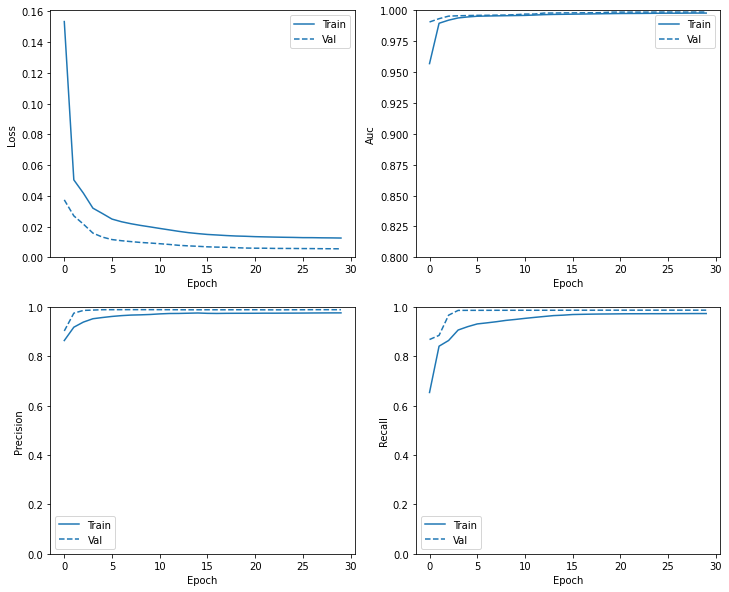

In [35]:
plot_metrics(baseline_history)

### Evaluate metrics

Evaluate your model on the test dataset and display the results for the metrics you created above.

In [36]:
baseline_results = model_base.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_base.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.005558967124670744
tp :  696766.0
fp :  8587.0
tn :  9888979.0
fn :  10203.0
accuracy :  0.9982283711433411
precision :  0.9878259301185608
recall :  0.9855679869651794
auc :  0.9985084533691406



## Step 6. Class Weights

**Calculate class weights**

The goal is to identify intrusions, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = df.shape[0] 
class_counts = df['Label'].value_counts()

In [33]:
weight_for_0 = (1 / class_counts[0])*(total)/15.0 
weight_for_1 = (1 / class_counts[1])*(total)/15.0 
weight_for_2 = (1 / class_counts[2])*(total)/15.0 
weight_for_3 = (1 / class_counts[3])*(total)/15.0 
weight_for_4 = (1 / class_counts[4])*(total)/15.0 
weight_for_5 = (1 / class_counts[5])*(total)/15.0 
weight_for_6 = (1 / class_counts[6])*(total)/15.0 
weight_for_7 = (1 / class_counts[7])*(total)/15.0 
weight_for_8 = (1 / class_counts[8])*(total)/15.0 
weight_for_9 = (1 / class_counts[9])*(total)/15.0 
weight_for_10 = (1 / class_counts[10])*(total)/15.0 
weight_for_11 = (1 / class_counts[11])*(total)/15.0 
weight_for_12 = (1 / class_counts[12])*(total)/15.0 
weight_for_13 = (1 / class_counts[13])*(total)/15.0 
weight_for_14 = (1 / class_counts[14])*(total)/15.0 
 
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5,6: weight_for_6, 7: weight_for_7, 8: weight_for_8, 9: weight_for_9, 10: weight_for_10, 11: weight_for_11, 12: weight_for_12, 13: weight_for_13, 14: weight_for_14 }

In [34]:
weighted_model = make_model()
 
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=90, #EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/90
777/777 [==============================] - 12s 12ms/step - loss: 5.9193 - tp: 38421.1003 - fp: 138640.0064 - tn: 11029043.5707 - fn: 759270.6838 - accuracy: 0.9275 - precision: 0.2304 - recall: 0.0352 - auc: 0.5686 - val_loss: 0.3587 - val_tp: 58854.0000 - val_fp: 205232.0000 - val_tn: 7217946.0000 - val_fn: 471373.0000 - val_accuracy: 0.9149 - val_precision: 0.2229 - val_recall: 0.1110 - val_auc: 0.4894
Epoch 2/90
777/777 [==============================] - 8s 11ms/step - loss: 1.9295 - tp: 82632.3535 - fp: 334502.8355 - tn: 10833184.0913 - fn: 715059.4306 - accuracy: 0.9125 - precision: 0.1974 - recall: 0.1021 - auc: 0.4847 - val_loss: 0.3937 - val_tp: 72557.0000 - val_fp: 212131.0000 - val_tn: 7211047.0000 - val_fn: 457670.0000 - val_accuracy: 0.9158 - val_precision: 0.2549 - val_recall: 0.1368 - val_auc: 0.4723
Epoch 3/90
777/777 [==============================] - 8s 11ms/step - loss: 1.5875 - tp: 89346.4267 - fp: 369916.0925 - tn: 10797768.2121 - fn: 708345.3573 - accura

### Check training history

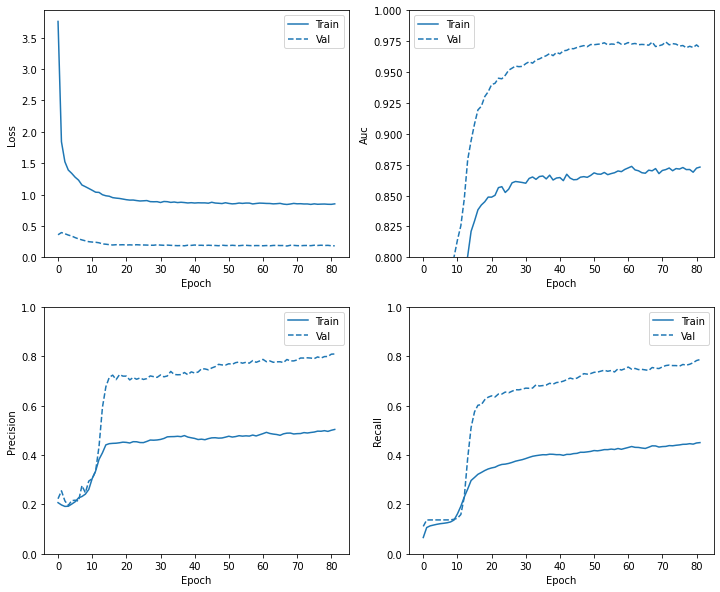

In [35]:
plot_metrics(weighted_history)

Evaluate metrics

In [36]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

loss :  0.4016915559768677
tp :  499030.0
fp :  182232.0
tn :  9715334.0
fn :  207939.0
accuracy :  0.9632071852684021
precision :  0.7325081825256348
recall :  0.7058725357055664
auc :  0.9429983496665955



The results are worser than baseline model.

## Step 7. Build Conv1D model

In [37]:
#hyper-params
batch_size = 2048 # increasing batch size with more gpu added
input_dim = X_train.shape[1]
num_class = 15                   # 15 intrusion classes, including benign traffic class
num_epochs = 30
learning_rates = 1e-3
regularizations = 1e-3
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

print(input_dim)
print(num_class)

73
15


In [38]:
#X_train_r = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_r = np.zeros((len(X_train), input_dim, 1))
X_train_r[:, :, 0] = X_train[:, :input_dim]
print(X_train_r.shape)

(1590680, 73, 1)


In [39]:
X_test_r = np.zeros((len(X_test), input_dim, 1))
X_test_r[:, :, 0] = X_test[:, :input_dim]
print(X_test_r.shape)

(706969, 73, 1)


In [40]:
X_val_r = np.zeros((len(X_val), input_dim, 1))
X_val_r[:, :, 0] = X_val[:, :input_dim]
print(X_val_r.shape)

(530227, 73, 1)


In [41]:
model = Sequential()

# input layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(73,1)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))


model.add(Conv1D(filters=128, kernel_size=3))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_class))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 73, 64)            256       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 64)            292       
_________________________________________________________________
activation (Activation)      (None, 73, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 71, 128)           284       
_________________________________________________________________
activation_1 (Activation)    (None, 71, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 9088)             

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

## Step 9. Training the model

In [43]:
# fit network
model.fit(X_train_r, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val_r, y_val), verbose=1)

Epoch 1/30
777/777 [==============================] - 38s 41ms/step - loss: 0.1234 - accuracy: 0.9743 - val_loss: 0.0054 - val_accuracy: 0.9987
Epoch 2/30
777/777 [==============================] - 32s 41ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0030 - val_accuracy: 0.9990
Epoch 3/30
777/777 [==============================] - 32s 41ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 0.9993
Epoch 4/30
777/777 [==============================] - 32s 41ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 5/30
777/777 [==============================] - 32s 41ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9994
Epoch 6/30
777/777 [==============================] - 32s 41ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 7/30
777/777 [==============================] - 32s 41ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy:

In [44]:
# evaluate model
accuracy = model.evaluate(X_test_r, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

[3.559359312057495, 0.9409549832344055]


Save the model

In [ ]:
model.save('/content/drive/My Drive/CICIDS2017/cicids2017cnn.h5')

## Step 8. Calculate Precision, Recall, and F-sore

Classification accuracy is the total number of correct predictions divided by the total number of predictions made for a dataset. As a performance measure, accuracy is inappropriate for imbalanced classification problems. The main reason is that the overwhelming number of examples from the majority class (or classes) will overwhelm the number of examples in the minority class, meaning that even unskillful models can achieve accuracy scores of 90 percent, or 99 percent, depending on how severe the class imbalance happens to be.

An alternative to using classification accuracy is to use precision and recall metrics.

In [45]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [47]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_r, verbose=0)

# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test_r, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [48]:
print(yhat_probs.shape)
print(y_test_ada.shape)

(706969,)
(706969,)


**Accuracy**

In [49]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_ada, yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.940955


**Precision**

Precision calculates the accuracy for the minority class. It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted.

In [50]:
# precision tp / (tp + fp)
precision = precision_score(y_test_ada, yhat_classes, labels=[1,2], average='micro')
# labels is a list of all possible class labels
print('Precision: %f' % precision)

Precision: 0.999392


**Recall**

Recall is the ratio of true positives to the ground-truth positives in the sample. Unlike Precision, Recall also considers the number of positive (minority) cases that were not classified as such.

In [51]:
# recall: tp / (tp + fn)
recall = recall_score(y_test_ada, yhat_classes, average='weighted')
print('Recall: %f' % recall)

Recall: 0.940955


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**F-Score**

Precision is appropriate when we are more concerned with minimizing false positives, while Recall is appropriate when the number of false negatives is more critica

In [52]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_ada, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.940955


In [53]:
# kappa
kappa = cohen_kappa_score(y_test_ada, yhat_classes)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(y_test_ada, yhat_classes)
print(matrix)

Cohens kappa: 0.829412
[[567782     20      0      0      0      0      0      0      0      1
       0      1      1      0      1]
 [    17    461      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     1      0  32396      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0   2541     17      1      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0  57296      2      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      2     17   1297      2      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      4      4   1472      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0   1977      0      0
       0      6      0      0      0]
 [     3      0      0      0      0      0      0      0      0      3
       0      0      0   

## Step 9. Using CNN2D Model

Convert each example as a 9x8 gray image.

Each example has 73 features. Drop the last column (idle min) to have 72 features such that we can have 9x8 gray images.

In [19]:
 X_train_enlarge = X_train[:,:-1]
 print(X_train_enlarge.shape)

(1590680, 72)


In [20]:
X_val_enlarge =  X_val[:,:-1]
X_test_enlarge =  X_test[:,:-1]

In [21]:
img_row = 9
img_col = 8

X_train_gray = np.array([x.reshape(img_row, img_col,1) for x in X_train_enlarge])
train_gray = np.array([x.reshape(img_row, img_col) for x in X_train_enlarge])

In [22]:
X_test_gray = np.array([x.reshape(img_row, img_col,1) for x in X_test_enlarge])
test_gray = np.array([x.reshape(img_row, img_col) for x in X_test_enlarge])

In [22]:
X_val_gray = np.array([x.reshape(img_row, img_col,1) for x in X_val_enlarge])
val_gray =  np.array([x.reshape(img_row, img_col) for x in X_val_enlarge])

In [29]:
X_train_gray.shape

(1590680, 9, 8, 1)

In [30]:
X_test_gray.shape

(706969, 9, 8, 1)

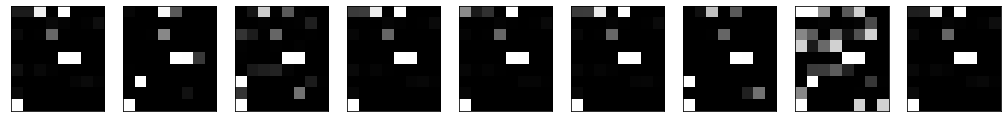

In [31]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

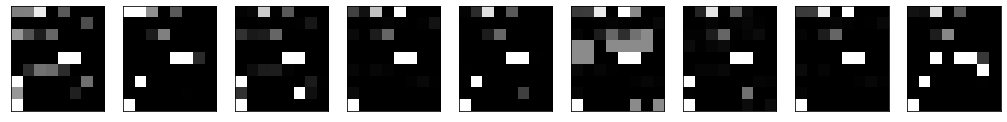

In [32]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

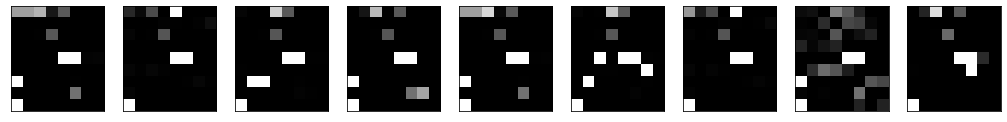

In [33]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(1,10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(val_gray[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [24]:
batch_size = 50 # increasing batch size with more gpu added
 
num_class = 15                   # 15 intrusion classes, including benign traffic class
epochs = 40

In [25]:
model2d_g = Sequential()
model2d_g.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(9,8,1)))
model2d_g.add(Conv2D(64, kernel_size=(3,3), padding='same',  activation='relu'))
model2d_g.add(Flatten())
model2d_g.add(Dropout(0.2))
model2d_g.add(Dense(512))
model2d_g.add(Dense(num_class, activation='softmax'))
 
model2d_g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 8, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 8, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 2,386,319
Trainable params: 2,386,319
Non-trainable params: 0
______________________________________________

In [26]:
# training
model2d_g.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001), #,SGD(lr=0.01), #
              metrics=['accuracy'])

In [27]:
model2d_g.fit(X_train_gray, y_train,
          batch_size=50, #batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_gray, y_val))

Epoch 1/40
31814/31814 [==============================] - 145s 4ms/step - loss: 0.0216 - accuracy: 0.9951 - val_loss: 0.0090 - val_accuracy: 0.9973
Epoch 2/40
31814/31814 [==============================] - 134s 4ms/step - loss: 0.0104 - accuracy: 0.9979 - val_loss: 0.0124 - val_accuracy: 0.9984
Epoch 3/40
31814/31814 [==============================] - 134s 4ms/step - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0081 - val_accuracy: 0.9982
Epoch 4/40
31814/31814 [==============================] - 133s 4ms/step - loss: 0.0105 - accuracy: 0.9981 - val_loss: 0.0078 - val_accuracy: 0.9989
Epoch 5/40
31814/31814 [==============================] - 134s 4ms/step - loss: 0.0109 - accuracy: 0.9982 - val_loss: 0.0175 - val_accuracy: 0.9977
Epoch 6/40
31814/31814 [==============================] - 133s 4ms/step - loss: 0.0110 - accuracy: 0.9983 - val_loss: 0.0071 - val_accuracy: 0.9988
Epoch 7/40
 4752/31814 [===>..........................] - ETA: 1:34 - loss: 0.0101 - accuracy: 0.9982

KeyboardInterrupt: ignored

In [ ]:
# evaluate model
accuracy = model2d_g.evaluate(X_test_gray, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

[0.07864858955144882, 0.9820713400840759]


Convert each example as a 6x4 color image.

In [ ]:
img_row = 6
img_col = 4

X_train_img = np.array([x.reshape(img_row, img_col, 3) for x in X_train_enlarge])
X_val_img = np.array([x.reshape(img_row, img_col, 3) for x in X_val_enlarge])
X_test_img = np.array([x.reshape(img_row, img_col, 3) for x in X_test_enlarge])

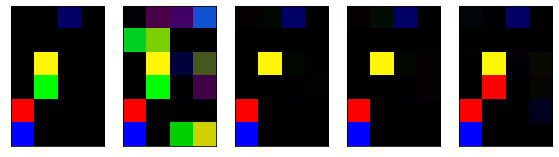

In [ ]:
#ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

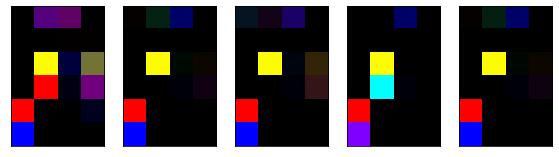

In [ ]:
n = 40  # how many digits we will display
plt.figure(figsize=(80, 30))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_test_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [ ]:
model2d = Sequential()
model2d.add(Conv2D(32, kernel_size=(1, 1), padding='same', activation='relu', input_shape=(6,4,3)))
model2d.add(Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu'))
model2d.add(Flatten()) 
model2d.add(Dropout(0.1))
model2d.add(Dense(512))
model2d.add(Dense(num_class, activation='softmax'))
 
model2d.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 6, 4, 32)          128       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 6, 4, 64)          2112      
_________________________________________________________________
flatten_25 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               786944    
_________________________________________________________________
dense_51 (Dense)             (None, 15)                7695      
Total params: 796,879
Trainable params: 796,879
Non-trainable params: 0
_______________________________________________

In [ ]:
# training
model2d.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.01), #,SGD(lr=0.01), #
              metrics=['accuracy'])
model2d.fit(X_train_img, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_img, y_val))

Epoch 1/40
557/557 [==============================] - 4s 6ms/step - loss: 0.7221 - accuracy: 0.7703 - val_loss: 0.2294 - val_accuracy: 0.9005
Epoch 2/40
557/557 [==============================] - 3s 6ms/step - loss: 0.2083 - accuracy: 0.9291 - val_loss: 0.2261 - val_accuracy: 0.8936
Epoch 3/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1720 - accuracy: 0.9440 - val_loss: 0.1358 - val_accuracy: 0.9522
Epoch 4/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1463 - accuracy: 0.9507 - val_loss: 0.1972 - val_accuracy: 0.9365
Epoch 5/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1388 - accuracy: 0.9526 - val_loss: 0.1799 - val_accuracy: 0.9016
Epoch 6/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1359 - accuracy: 0.9545 - val_loss: 0.2031 - val_accuracy: 0.9002
Epoch 7/40
557/557 [==============================] - 3s 6ms/step - loss: 0.1221 - accuracy: 0.9585 - val_loss: 0.3816 - val_accuracy: 0.8337
Epoch 

In [ ]:
# evaluate model
accuracy = model2d.evaluate(X_test_img, y_test, batch_size=batch_size, verbose=0)
print(accuracy)

[0.14182227849960327, 0.9685341715812683]


## Step 10. DNN Model 

In [ ]:
model_dnn = Sequential()

# input layer
model_dnn.add(Dense(128,  activation='relu', input_shape = (71,)))
model_dnn.add(Dropout(0.1))

# hidden layer
model_dnn.add(Dense(256, activation='relu'))
model_dnn.add(Dropout(0.1))

# hidden layer
model_dnn.add(Dense(64, activation='relu'))
model_dnn.add(Dropout(0.1))

model_dnn.add(Flatten()) 
model_dnn.add(Dense(num_class))
model_dnn.add(Activation('softmax'))


model_dnn.summary()

In [ ]:
learning_rates = 1e-4
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model_dnn.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [ ]:
# fit network
model_dnn.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

In [ ]:
# evaluate model
accuracy = model.evaluate(X_test_r, y_test, batch_size=batch_size, verbose=1)

## Step 11. PCA Modol

Perform basic exploratory analysis

In [ ]:
df_train.head()

,,,,,,,,,,,,,,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
5141,172.16.0.1-192.168.10.50-50294-80-6,172.16.0.1,50294.0,192.168.10.50,80.0,6.0,5/7/2017 10:33,63101744.0,7.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.110932,10500000.0,1.190000e+07,32100000.0,998158.0,63100000.0,1.050000e+07,1.190000e+07,32100000.0,998158.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.110932,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,29200.0,-1.0,0.0,40.0,7006133.0,0.0,7006133.0,7006133.0,18700000.0,12200000.0,32100000.0,8015895.0,DoS Slowhttptest
40963,172.16.0.1-192.168.10.50-37796-1199-6,172.16.0.1,37796.0,192.168.10.50,1199.0,6.0,7/7/2017 2:52,62.0,1.0,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,6.0,6.0,6.0,0.0,1.290323e+05,32258.064520,62.0,0.000000e+00,62.0,62.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.0,16129.032260,16129.032260,2.0,6.0,3.333333,2.309401,5.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.000000,2.000000,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,6.0,1024.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
27718,172.217.6.200-192.168.10.12-443-42634-6,172.217.6.200,443.0,192.168.10.12,42634.0,6.0,03/07/2017 09:49:12,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,666666.666667,3.0,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,357.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
106492,192.168.10.8-23.208.79.206-52235-443-6,192.168.10.8,52235.0,23.208.79.206,443.0,6.0,4/7/2017 11:46,5007496.0,7.0,4.0,1679.0,152.0,1080.0,0.0,239.857143,415.237052,152.0,0.0,38.0,76.0,3.656518e+02,2.196707,500749.6,1.543257e+06,4892570.0,3.0,5007496.0,8.345827e+05,2.018795e+06,4955369.0,3.0,87090.0,29030.0,31709.63089,63179.0,515.0,0.0,0.0,0.0,0.0,152.0,92.0,1.397904,0.798802,0.0,1080.0,152.583333,327.660428,107361.356100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,166.454545,239.857143,38.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1679.0,4.0,152.0,8192.0,946.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
63559,192.168.10.14-52.84.30.203-59835-80-6,52.84.30.203,80.0,192.168.10.14,59835.0,6.0,6/7/2017 10:04,4.0,1.0,1.0,6.0,6.0,6.0,6.0,6.000000,0.000000,6.0,6.0,6.0,0.0,3.000000e+06,500000.000000,4.0,0.000000e+00,4.0,4.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,250000.000000,250000.000000,6.0,6.0,6.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.000000,6.000000,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,115.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

Text(0.5, 1.0, 'Correlation between different fearures')

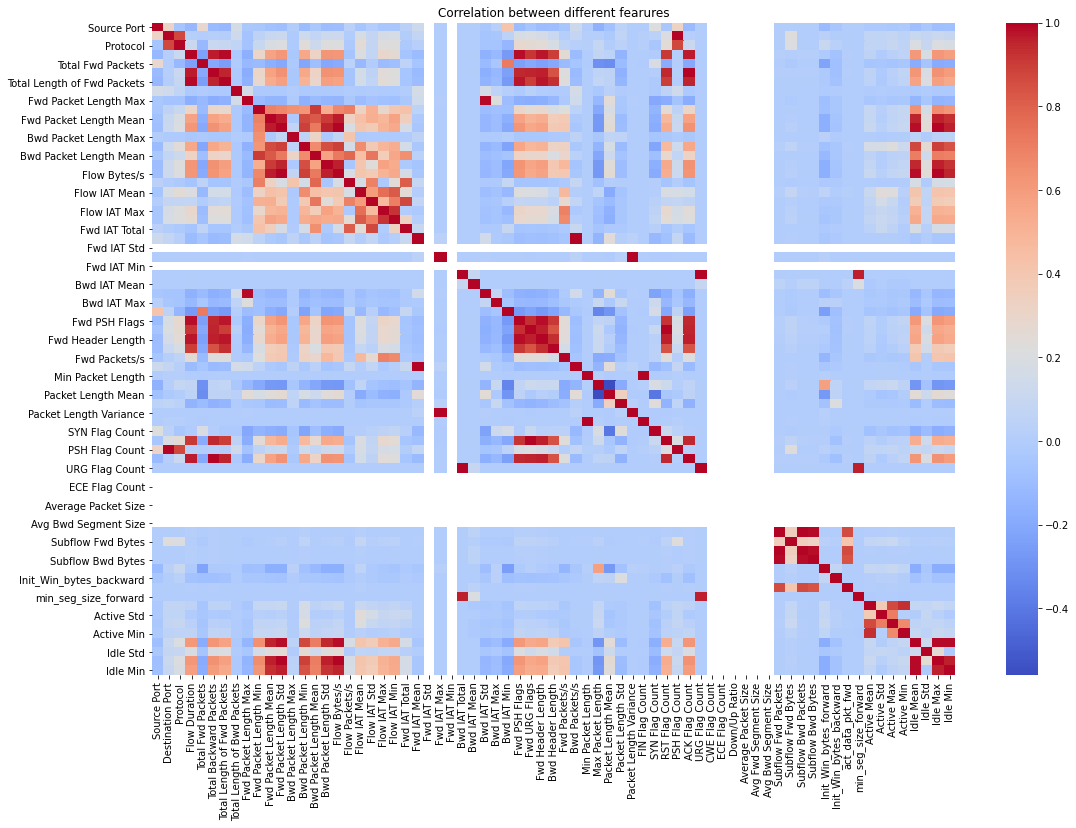

In [ ]:
correlation = df_train.corr()
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
sns.heatmap(correlation,ax= ax, cmap='coolwarm')

plt.title('Correlation between different fearures')

In [ ]:
X_pca = df_train.drop('Label',axis=1)
y_pca = df_train['Label']

In [ ]:
X_pca = scaler.fit_transform(X_pca)

In [ ]:
dfx = pd.DataFrame(data=X_pca,columns=df_train.columns[1:])

In [ ]:
dfx.head(10)

,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005761,0.400000,8.750002e-02,1.406619e-01,2.675000e-01,8.318091e-03,5.258333e-01,8.750000e-02,0.142686,2.675000e-01,8.317992e-03,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.998038,0.968973,3.697732e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000030,0.000000e+00,0.000000,0.000000e+00,0.445572,0.000000,0.000000,1.0,6.369212e-02,0.0,6.369212e-02,6.369212e-02,0.155833,0.164199,0.267500,0.066799
1,0.000860,0.000337,0.000000,0.000307,0.003026,0.001034,0.000000,0.005823,0.406452,5.333333e-07,0.000000e+00,5.333333e-07,6.249999e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.333333e-09,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.998038,0.968973,5.376344e-03,8.064516e-03,0.001381,0.000242,0.001142,0.000488,2.380952e-07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.011111,0.001498,0.000337,0.001034,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.978099e-07,0.000004,9.568759e-09,0.015640,0.000015,0.000000,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005761,0.533333,4.166667e-08,0.000000e+00,4.166667e-08,1.333333e-07,2.500000e-08,2.500000e-08,0.000000,2.500000e-08,3.333333e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.998038,0.968973,2.222222e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.000000e+00,0.000000,0.000000e+00,0.005463,0.000000,0.000000,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.040374,0.058274,0.007783,0.000000,0.006551,0.009274,0.005761,0.400000,4.172930e-03,1.824181e-02,4.077143e-02,1.333333e-07,4.172913e-02,6.954856e-03,0.024206,4.129474e-02,3.333333e-08,7.257500e-04,2.419167e-04,0.000382,5.264917e-04,4.291667e-06,0.0,0.0,0.0,0.0,0.998038,0.968974,4.659681e-07,3.994012e-07,0.000000,0.043513,0.052255,0.069251,4.792918e-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.049879,0.040374,0.006551,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000030,5.858114e-04,0.000015,2.424086e-07,0.125015,0.014450,0.000021,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,0.002581,0.001010,0.000000,0.000307,0.003026,0.001034,0.000000,0.007201,0.500000,5.000000e-08,0.000000e+00,5.000000e-08,1.416667e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.333333e-09,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.998038,0.968973,8.333333e-02,1.250000e-01,0.004144,0.000242,0.002055,0.000000,0.00000

In [ ]:
dfx.describe()

,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,556548.000000,5.565480e+05,5.565480e+05,556548.000000,5.565480e+05,556548.000000,556548.000000,5.565480e+05,5.565480e+05,5.565480e+05,556548.000000,5.565480e+05,5.565480e+05,556548.000000,556548.0,556548.000000,556548.0,556548.000000,556548.000000,5.565480e+05,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.000000,556548.0,556548.0,556548.0,556548.0,556548.0,556548.0,556548.000000,5.565480e+05,556548.000000,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000,5.565480e+05,556548.000000,5.565480e+05,5.565480e+05,556548.000000,556548.000000,556548.000000,556548.000000
mean,0.005401,0.007637,0.008393,0.082061,0.013281,0.091317,0.080882,0.006271,0.416054,1.582110e-02,0.058956,1.369179e-01,1.532107e-03,0.166690,3.085272e-02,0.076517,0.135929,6.945659e-03,7.877244e-02,1.528014e-02,0.026972,5.083254e-02,6.051411e-03,0.033627,0.0,0.000056,0.0,0.998035,0.968971,2.412223e-02,3.973047e-03,0.007356,0.066598,0.091877,0.110242,4.716877e-02,0.061905,0.033627,0.000162,0.359261,0.359924,0.062144,0.000056,0.000162,0.007305,0.088824,0.007637,0.091317,0.998035,0.0,0.0,0.0,0.0,0.0,0.0,0.000029,1.411228e-04,0.000025,1.654270e-05,0.109081,0.020661,0.000018,0.999997,8.157713e-04,0.000459,1.264051e-03,6.395897e-04,0.127947,0.011880,0.133545,0.122500
std,0.023972,0.025478,0.031453,0.142375,0.029291,0.146755,0.149432,0.010977,0.055251,4.147565e-02,0.120777,2.774879e-01,2.738831e-02,0.314806,8.130881e-02,0.163910,0.278035,6.588999e-02,2.333813e-01,6.941998e-02,0.102431,1.767976e-01,6.024664e-02,0.180267,0.0,0.007463,0.0,0.001464,0.001454,9.003157e-02,1.926990e-02,0.015077,0.112956,0.140252,0.187204,1.078500e-01,0.240983,0.180267,0.012716,0.479784,0.479978,0.241417,0.007463,0.012716,0.007252,0.134636,0.025478,0.146755,0.001464,0.0,0.0,0.0,0.0,0.0,0.0,0.002399,2.244618e-03,0.002306,2.532983e-03,0.204332,0.105313,0.002098,0.001389,6.247831e-03,0.005181,8.703029e-03,5.752383e-03,0.270808,0.085267,0.278004,0.268998
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.00000

PCA class import and analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=None)

In [ ]:
dfx_pca = pca.fit(dfx)

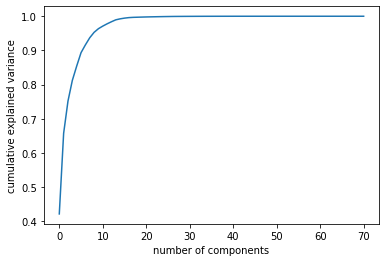

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


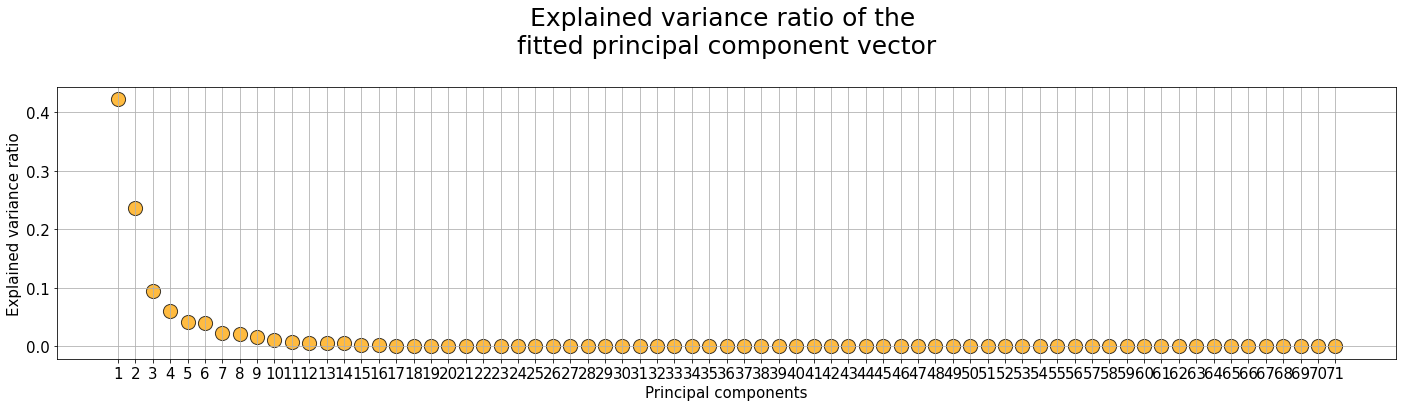

In [ ]:
plt.figure(figsize=(24,5))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

The above two plots means that the $1^{st}$ principal component explains about 42% of the total variance in the data and the $2^{nd}$ component explians further 24%. Therefore, if we just consider first two components, they together explain 66% of the total variance. Using the first 10 features should give very hight detection rate.

Transform the scaled data set using the fitted PCA object

In [ ]:
dfx_trans = pca.transform(dfx)


Put it in a data frame

In [ ]:
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,-0.095156,0.664727,0.097788,0.469011,-0.274898,-0.195548,0.129264,-0.079400,0.117194,-0.206700,0.249597,-0.058098,0.054795,0.033890,-0.024770,0.045114,0.023405,0.060974,-0.052816,-0.000568,0.037681,0.021733,0.003554,-0.028235,-0.050118,-0.034254,0.054225,0.122226,0.013727,-0.000427,0.002165,0.013844,-0.007412,-0.019688,0.007994,-0.016039,-0.023171,0.000124,-0.008058,0.001487,-0.013462,-0.006928,-0.005753,-0.000138,0.000536,0.000442,-0.000066,-0.004424,0.000949,4.308142e-03,-0.001622,-1.259158e-05,0.002177,3.876767e-05,-5.936133e-04,7.679856e-07,-1.293447e-05,1.970203e-15,3.891966e-17,1.726104e-17,-2.511318e-17,2.334794e-17,-1.417808e-16,-3.440081e-18,-1.064370e-17,8.747514e-19,-4.372389e-17,2.194897e-17,2.461635e-17,1.127823e-18,6.253272e-17
1,-0.645994,0.450095,0.050469,0.151210,-0.108255,-0.084455,0.055631,-0.075773,-0.288376,-0.007317,0.023899,-0.023022,-0.018042,-0.024695,-0.022278,-0.001592,0.001973,-0.003486,-0.001394,0.001929,-0.000463,-0.000062,0.000819,-0.002247,0.003955,-0.000327,-0.000402,0.000035,-0.002139,0.000059,0.002708,-0.002324,0.001185,0.000317,-0.001053,0.001098,-0.000242,0.001582,0.000791,-0.000173,0.000261,0.000050,-0.000396,0.000003,0.000043,-0.000023,-0.000028,-0.000005,0.000001,-3.156381e-07,-0.000045,-2.544763e-08,0.000001,9.928819e-07,7.334710e-06,2.659675e-07,-2.215707e-06,-2.736859e-15,2.497088e-17,-2.122664e-17,-5.469492e-17,-4.654579e-17,-1.949870e-16,1.979465e-17,-2.618159e-18,4.054071e-18,-1.218186e-17,7.673252e-19,1.933709e-17,1.649726e-18,1.480603e-17
2,-0.159507,-0.801662,0.092926,0.028379,-0.038332,-0.025742,-0.330583,-0.012501,-0.061069,0.077176,-0.013670,-0.028986,0.016374,0.114091,0.003156,-0.001289,0.003967,0.002122,0.000754,-0.001848,0.002252,-0.000572,-0.000924,-0.006769,0.002925,-0.000043,-0.001141,0.001497,-0.001946,0.000569,-0.001958,-0.001467,-0.000564,0.001370,-0.000459,0.000696,-0.000556,-0.000824,-0.000672,0.000112,-0.000119,0.000195,-0.000078,-0.000008,-0.000093,0.000011,-0.000018,-0.000105,0.000033,2.446211e-05,-0.000016,4.060178e-06,-0.000001,8.389281e-07,-8.767417e-07,-1.590482e-06,-2.056437e-06,-7.137926e-16,7.927990e-17,6.059768e-17,-2.257305e-17,-7.689561e-17,1.743907e-16,1.132814e-17,1.574579e-17,-7.074719e-18,2.361855e-17,9.732725e-19,-2.930078e-17,-1.081186e-18,-8.555343e-17
3,-0.576326,0.505473,0.104462,0.145619,-0.090991,-0.067814,0.053936,-0.078472,-0.177577,-0.013632,0.033840,-0.014352,-0.026713,-0.016988,0.028498,0.083098,-0.012998,0.008017,0.024594,-0.027867,0.025977,0.004395,0.001102,-0.004066,0.000150,-0.006480,-0.007202,-0.005387,0.005746,0.000946,-0.005618,-0.003186,-0.004149,-0.001257,0.007187,-0.003093,0.001145,-0.005653,0.000715,0.000176,0.000696,0.003941,-0.001524,-0.000024,0.000537,-0.000378,0.000017,0.000064,-0.000012,-3.141683e-05,-0.000027,-1.753731e-05,-0.000286,-1.468086e-05,-2.054745e-05,-4.301230e-07,5.800489e-06,5.219556e-15,1.631856e-17,-2.670536e-17,-3.929467e-17,-2.602768e-17,-1.984960e-16,7.391299e-18,-4.087365e-18,3.462406e-18,-1.435727e-17,-2.940798e-18,1.917311e-17,2.117557e-18,1.426243e-16
4,-0.167499,-0.952517,0.164458,0.167295,-0.084639,0.729470,0.285573,-0.004181,-0.066513,-0.009234,-0.015874,-0.130429,0.062856,0.093742,-0.011723,-0.027108,-0.008933,0.004549,-0.007271,0.015118,-0.003010,0.008564,-0.005336,0.110738,-0.028012,-0.000207,0.000991,0.001593,0.002628,-0.000528,-0.003629,0.002641,0.003167,-0.001367,0.000764,-0.002761,0.001381,-0.005688,-0.002596,0.000420,0.000035,0.000451,-0.000182,-0.000011,0.000371,0.000069,0.000296,-0.000226,0.000083,-7.387700e-05,0.000060,1.001567e-05,-0.000038,-1.247422e-06,1.275383e-05,-3.705704e-07,7.882997e-07,-1.008273e-15,7.253878e-17,3.738838e-17,-1.264763e-17,-3.588810e-17,1.546785e-16,4.659910e-17,2.915851e-17,8.355731e-19,3.265762e-17,1.007676e-17,-3.113206e-17,-1.226630e-17,-1.153850e-16
5,-0

### Training and Making Predictions
In this case we'll use random forest classification for making the predictions.

In [ ]:
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_pca, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test_pca)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#cm = confusion_matrix(y_test_ada, y_pred)
#print(cm)
print('Accuracy:%f' %accuracy_score(y_test, y_pred))

Accuracy:0.638657


## Step 13. KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
features_order = ['Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min']

In [ ]:
features=["Fwd Packet Length Max","Flow IAT Std","Fwd Packet Length Std" ,"Fwd IAT Total",'Flow Packets/s', "Fwd Packet Length Mean",  "Flow Bytes/s",  "Flow IAT Mean", "Bwd Packet Length Mean",  "Flow IAT Max", "Bwd Packet Length Std", ]

**Import module for KNN**

First, convert numpy array to dataframe

In [ ]:
df_train = pd.DataFrame(X_train, columns = features_order)
df_train.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005761,0.400000,8.750002e-02,0.140662,2.675000e-01,8.318091e-03,5.258333e-01,8.750000e-02,0.142686,2.675000e-01,8.317992e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.998038,0.968973,3.697732e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000030,0.000000e+00,0.000000,0.000000e+00,0.445572,0.000000,0.000000,1.0,0.063692,0.0,0.063692,0.063692,0.155833,0.164199,0.2675,0.066799
1,0.000860,0.000337,0.000000,0.000307,0.003026,0.001034,0.000000,0.005823,0.406452,5.333333e-07,0.000000,5.333333e-07,6.249999e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.333333e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.998038,0.968973,5.376344e-03,8.064516e-03,0.001381,0.000242,0.001142,0.000488,2.380952e-07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.011111,0.001498,0.000337,0.001034,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.978099e-07,0.000004,9.568759e-09,0.015640,0.000015,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005761,0.533333,4.166667e-08,0.000000,4.166667e-08,1.333333e-07,2.500000e-08,2.500000e-08,0.000000,2.500000e-08,3.333333e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.998038,0.968973,2.222222e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.000000e+00,0.000000,0.000000e+00,0.005463,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
3,0.000000,0.040374,0.058274,0.007783,0.000000,0.006551,0.009274,0.005761,0.400000,4.172930e-03,0.018242,4.077143e-02,1.333333e-07,4.172913e-02,6.954856e-03,0.024206,4.129474e-02,3.333333e-08,0.000726,0.000242,0.000382,0.000526,0.000004,0.0,0.0,0.0,0.0,0.998038,0.968974,4.659681e-07,3.994012e-07,0.000000,0.043513,0.052255,0.069251,4.792918e-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.049879,0.040374,0.006551,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000030,5.858114e-04,0.000015,2.424086e-07,0.125015,0.014450,0.000021,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
4,0.002581,0.001010,0.000000,0.000307,0.003026,0.001034,0.000000,0.007201,0.500000,5.000000e-08,0.000000,5.000000e-08,1.416667e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.333333e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.998038,0.968973,8.333333e-02,1.250000e-01,0.004144,0.000242,0.002055,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.011111,0.002697,0.001010,0.001034,0.998038,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.093430e-06,0.000004,9.568759e-09

In [ ]:
df_val = pd.DataFrame(X_val, columns = features_order)

Select a subset of features from the dataframe

In [ ]:
df_sub=df_train.loc[:, features]
df_sub.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Flow Packets/s,Fwd Packet Length Mean,Flow Bytes/s,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,0.400000,0.000000,2.675000e-01,0.000000,8.317992e-03,0.140662,2.675000e-01,0.000000,8.750000e-02,0.000000,0.142686
1,0.406452,0.000000,5.333333e-07,0.000000,8.333333e-09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
2,0.533333,0.000000,4.166667e-08,0.000000,3.333333e-08,0.000000,2.500000e-08,0.000000,2.500000e-08,0.000000,0.000000
3,0.400000,0.000242,4.077143e-02,0.000004,3.333333e-08,0.018242,4.129474e-02,0.000726,6.954856e-03,0.000382,0.024206
4,0.500000,0.000000,5.000000e-08,0.000000,8.333333e-09,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000


In [ ]:
df_val_sub=df_val.loc[:, features]
df_val_sub.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Flow Packets/s,Fwd Packet Length Mean,Flow Bytes/s,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,0.375000,0.000000e+00,7.500000e-08,0.000000e+00,9.999999e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
1,0.333343,2.507450e-04,1.142575e-03,3.750000e-07,2.166666e-07,0.000574,1.084083e-04,1.253725e-03,5.426250e-05,0.000727,0.000110
2,0.333333,0.000000e+00,4.687906e-02,0.000000e+00,3.089833e-04,0.038677,4.687905e-02,0.000000e+00,2.359397e-02,0.000000,0.047212
3,0.342342,0.000000e+00,3.166667e-07,0.000000e+00,9.999999e-08,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
4,0.333355,3.333333e-08,2.569083e-04,3.333333e-08,1.333333e-07,0.000213,3.333333e-08,3.333333e-08,3.333333e-08,0.000000,0.000000


Convert dataframes to numpy array

In [ ]:
X_train = df_sub.to_numpy()
X_val = df_val_sub.to_numpy()

In [ ]:
for i in range(1,X_train.shape[1]+1):
    knn=KNeighborsClassifier(n_neighbors=i)
    model_knn=knn.fit(X_train,y_train)
    yhat=model_knn.predict(X_val)
    print("for " , i,  " as K, accuracy is : ", accuracy_score(y_val, yhat))

for  1  as K, accuracy is :  0.7452078916160564
for  2  as K, accuracy is :  0.7219606856650016
for  3  as K, accuracy is :  0.7452905451539872
for  4  as K, accuracy is :  0.7432673302907248
for  5  as K, accuracy is :  0.7459050562403421
for  6  as K, accuracy is :  0.7444316670859238
for  7  as K, accuracy is :  0.7461602041183024
for  8  as K, accuracy is :  0.7449275883135085
for  9  as K, accuracy is :  0.7462069213353937
for  10  as K, accuracy is :  0.7409135012757394
for  11  as K, accuracy is :  0.7503144428073454


## Step 14. Random Foresty with DecisionTree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=10)
clf.fit(X_train,y_train)
    
pred = clf.predict(X_val)
val_acc = metrics.accuracy_score(y_val,pred)*100        
print('val acc:',val_acc)

val acc: 75.54677112157258


## Step 12. PLS Model

In [ ]:
from scipy import linalg

from sklearn.utils import check_array
from sklearn.utils.validation import FLOAT_DTYPES
from sklearn.base import BaseEstimator
from sklearn.preprocessing import normalize
import copy

In [ ]:
class CIPLS(BaseEstimator):
    """Covariance-free Partial Least Squares (CIPLS).
    Parameters
    ----------
    n_components : int or None, (default=None)
        Number of components to keep. If ``n_components `` is ``None``,
        then ``n_components`` is set to ``min(n_samples, n_features)``.
    copy : bool, (default=True)
        If False, X will be overwritten. ``copy=False`` can be used to
        save memory but is unsafe for general use.
    References
    Covariance-free Partial Least Squares: An Incremental Dimensionality Reduction Method
    """

    def __init__(self, n_components=10, copy=True):
        self.__name__ = 'Covariance-free Partial Least Squares'
        self.n_components = n_components
        self.n = 0
        self.copy = copy
        self.sum_x = None
        self.sum_y = None
        self.n_features = None
        self.x_rotations = None
        self.x_loadings = None
        self.y_loadings = None
        self.eign_values = None
        self.x_mean = None
        self.p = []

    def normalize(self, x):
        return normalize(x[:, np.newaxis], axis=0).ravel()

    def fit(self, X, Y):
        X = check_array(X, dtype=FLOAT_DTYPES, copy=self.copy)
        Y = check_array(Y, dtype=FLOAT_DTYPES, copy=self.copy, ensure_2d=False)

        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)

        if np.unique(Y).shape[0] == 2:
            Y[np.where(Y == 0)[0]] = -1

        n_samples, n_features = X.shape

        if self.n == 0:
            self.x_rotations = np.zeros((self.n_components, n_features))
            self.x_loadings = np.zeros((n_features, self.n_components))
            self.y_loadings = np.zeros((Y.shape[1], self.n_components))
            self.n_features = n_features
            self.eign_values = np.zeros((self.n_components))
            self.p = [0] * self.n_components

        for j in range(0, n_samples):
            self.n = self.n + 1
            u = X[j]
            l = Y[j]

            if self.n == 1:
                self.sum_x = u
                self.sum_y = l
            else:
                old_mean = 1 / (self.n - 1) * self.sum_x
                self.sum_x = self.sum_x + u
                mean_x = 1 / self.n * self.sum_x
                u = u - mean_x
                delta_x = mean_x - old_mean
                self.x_rotations[0] = self.x_rotations[0] - delta_x * self.sum_y
                self.x_rotations[0] = self.x_rotations[0] + (u * l)
                self.sum_y = self.sum_y + l

                t = np.dot(u, self.normalize(self.x_rotations[0].T))

                self.x_loadings[:, 0] = self.x_loadings[:, 0] + (u * t)
                self.y_loadings[:, 0] = self.y_loadings[:, 0] + (l * t)

                for c in range(1, self.n_components):
                    u -= np.dot(t, self.x_loadings[:, c - 1])
                    l -= np.dot(t, self.y_loadings[:, c - 1])

                    self.x_rotations[c] = self.x_rotations[c] + (u * l)
                    self.x_loadings[:, c] = self.x_loadings[:, c] + (u * t)
                    self.y_loadings[:, c] = self.y_loadings[:, c] + (l * t)
                    t = np.dot(u, self.normalize(self.x_rotations[c].T))

        return self

    def transform(self, X, Y=None, copy=True):
        """Apply the dimension reduction learned on the train data."""
        X = check_array(X, copy=copy, dtype=FLOAT_DTYPES)
        mean = 1 / self.n * self.sum_x
        X -= mean
        w_rotation = np.zeros(self.x_rotations.shape)

        for c in range(0, self.n_components):
            w_rotation[c] = self.normalize(self.x_rotations[c])

        return np.dot(X, w_rotation.T)

In [ ]:
dm = CIPLS(n_components=12, copy=True)
dm.fit(X_train, y_train)
train_latent = dm.transform(X_train)

ValueError: ignored

## Step 15. AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

In [ ]:
model_ada = AdaBoostClassifier(n_estimators=100)
model_ada.fit(X_train, y_train_ada)

# make predictions
expected = y_val_ada
predicted = model_ada.predict(X_val)

In [ ]:
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
tpr = float(cm[0][0])/np.sum(cm[0])
fpr = float(cm[1][1])/np.sum(cm[1])
print("%.3f" %tpr)
print("%.3f" %fpr)
print("fpr")
print("%.3f" %fpr)
print("tpr")
print("%.3f" %tpr)
print("\nAccuracy:%f" %metrics.accuracy_score(y_val, predicted))
#print("\nPrecision:%f" %metrics.average_precision_score(y_val, predicted, average=None))
print("\nRecall:%f" %metrics.recall_score(y_val, predicted, average='weighted'))
print("\nF1-score:%f" %metrics.f1_score(y_val, predicted,average='weighted'))
print("\nconfusion matrix:" )
print("\n%s" %metrics.confusion_matrix(y_val, predicted))

[[138638      0      9      0    486      0      0      0      0      2
       0      0      0      0      0]
 [   489      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 11653      0   5264      0  15089      0      0      0      0      0
       0      0      0      0      0]
 [   851      0    118      0   1604      0      0      0      0      0
       0      0      0      0      0]
 [ 18725      0   1025      0  37781      0      0      0      0      0
       0      0      0      0      0]
 [  1355      0      0      0     19      0      0      0      0      0
       0      0      0      0      0]
 [  1449      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [  1983      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      2      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     8  

## Step x. Reorder features according to their importance. 

According to "Selection and Performance Analysis of CICIDS2017 Features Importance", the important features are: Destination Port, Fwd IAT Min, Init_Win_bytes_Forward, Init_Win_bytes_backward and FlowIATMin

In [ ]:
col_important = np.array(['Source Port', 'Destination Port', 'Fwd IAT Min', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Flow IAT Min',
                      'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Protocol', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label'])

Load the data again.

In [ ]:
# load train data
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set.csv',names=col_important, skiprows=1) 
df_train.head()

,,,,,,,,,,,,,,Source Port,Destination Port,Fwd IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow IAT Min,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Protocol,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
5141,172.16.0.1-192.168.10.50-50294-80-6,172.16.0.1,50294.0,192.168.10.50,80.0,6.0,5/7/2017 10:33,63101744.0,7.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.110932,10500000.0,1.190000e+07,32100000.0,998158.0,63100000.0,1.050000e+07,1.190000e+07,32100000.0,998158.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,280.0,0.0,0.110932,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,29200.0,-1.0,0.0,40.0,7006133.0,0.0,7006133.0,7006133.0,18700000.0,12200000.0,32100000.0,8015895.0,DoS Slowhttptest
40963,172.16.0.1-192.168.10.50-37796-1199-6,172.16.0.1,37796.0,192.168.10.50,1199.0,6.0,7/7/2017 2:52,62.0,1.0,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,6.0,6.0,6.0,0.0,1.290323e+05,32258.064520,62.0,0.000000e+00,62.0,62.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.0,16129.032260,16129.032260,2.0,6.0,3.333333,2.309401,5.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.000000,2.000000,6.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,6.0,1024.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
27718,172.217.6.200-192.168.10.12-443-42634-6,172.217.6.200,443.0,192.168.10.12,42634.0,6.0,03/07/2017 09:49:12,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,666666.666667,3.0,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,357.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
106492,192.168.10.8-23.208.79.206-52235-443-6,192.168.10.8,52235.0,23.208.79.206,443.0,6.0,4/7/2017 11:46,5007496.0,7.0,4.0,1679.0,152.0,1080.0,0.0,239.857143,415.237052,152.0,0.0,38.0,76.0,3.656518e+02,2.196707,500749.6,1.543257e+06,4892570.0,3.0,5007496.0,8.345827e+05,2.018795e+06,4955369.0,3.0,87090.0,29030.0,31709.63089,63179.0,515.0,0.0,0.0,0.0,0.0,152.0,92.0,1.397904,0.798802,0.0,1080.0,152.583333,327.660428,107361.356100,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,166.454545,239.857143,38.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1679.0,4.0,152.0,8192.0,946.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
63559,192.168.10.14-52.84.30.203-59835-80-6,52.84.30.203,80.0,192.168.10.14,59835.0,6.0,6/7/2017 10:04,4.0,1.0,1.0,6.0,6.0,6.0,6.0,6.000000,0.000000,6.0,6.0,6.0,0.0,3.000000e+06,500000.000000,4.0,0.000000e+00,4.0,4.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,250000.000000,250000.000000,6.0,6.0,6.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.000000,6.000000,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,115.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [ ]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set.csv',names=col_important, skiprows=1) 
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set.csv',names=col_important, skiprows=1) 
print('Validation set size: ', df_val.shape)

Test set size:  (278270, 72)
Validation set size:  (278270, 72)


Repeat most of above steps:

In [ ]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
X_train = data.values
y_train = encode_label(df_label.values)

Go back and restart from step 2.2

unfortrunately, the feature importance does not improve the accuracy.